In [65]:
#imports 
import mne
import numpy as np
import pandas as pd
import os
import glob
from matplotlib import pyplot as plt
import sys

import seaborn as sns
from itertools import product as prod

In [121]:
class eeg_dynamic_read:
    def __init__(self, file, montageFile):
        self.file=file
        self.montage=montageFile
    
    def read_eeg(self):
        eeg_type='read_'+self.file.split('.')[-1]
        method=getattr(self, eeg_type, lambda: 'Invalid Type')
        return method()
        
    def read_cnt(self):
        return mne.io.read_raw_cnt(self.file,self.montage)



class subject:
    def __init__(self, ID, data, montage, eventIDs):
        """
        Subject class the contain individual subject data and the methods necessary to 
        do all within subjects processing and analyses
        
        ID: (String/Int) - Subject Indetifier
        data : (String) - name of data file - automatically loaded into mne with dynamic read
        montage : (String) - name of monatage file automatically loaded into mne with dynamic read
        eventIDs : (Dict) - mapping of event names to event codes
        
        """
        self.ID=ID
        self.data=eeg_dynamic_read(data, montage).read_eeg()
        self.events=mne.find_events(self.data)
        self.event_ID=eventIDs
        self.sample_rate=self.data.info['sfreq']
        
        #data stores for sample data
        #electorde x event code x event x time
        self.sample_channels=None
        self.sample_store=None
        self.boot_store=None
    
    def get_item_eeg(self, tmin=-.2, tmax=.8, baseline=(None,0.0), 
                         events=None, chans=[], average=False, store=False):
        
        """function epochs the data and returns an electrode x event code x event x sample array, with option
        to store in the sample_store attribute.
          
        tmin : (float/int) - time in seconds to begin epoch
        tmax : (float/int) - time in seconds to end epoch
        baseline : (tuple of ints) - beginning, end of baseline period
        events : (list of strings) - list of events names to pull out
        chans : (list of strings) - list of channel names to get data from
        average : (boolean) : whether or not to average the data
        store : (boolean) : whether or not to store data in the class attribute
        
        """
        
        if not events:
            raise 'Event of Interest Must be specified'
        
        erp=mne.Epochs(self.data, events=self.events, event_id=self.event_ID, tmin=tmin,
                    tmax=tmax, baseline=baseline, preload=True)
        
        #swap axes 0,1
        if average:
            ret=erp[event].average(picks=chans)
        else:
            ret=np.array([erp[event].pick_channels(chans).get_data() for event in events])
            
            #strutuces the array
            ret=np.swapaxes(np.swapaxes(ret, 0, 2), 1, 2)
        
        #option to store the data as part of the class
        #or return in
        if store:
            self.sample_channels=chans
            self.sample_store=ret
        else:   
            return ret
    
        
    def random_draw(self, array, nDraws=100, sampleSize=10, replacement=True):
        '''
        returns an array of boot-strapped means along the last axis of the passed array
        
        array : (nD array)
        nDraws : (int) - number of means to generate
        sampleSize : (int) - number of sample to take on each draw
        replacment : (boolean) - replacement for draws
        '''
        
        if not (sampleSize < array.shape[len(array.shape)-1]) and not replacement:
            raise "Sampling without replacement is limited to N-1 samples. Check sample store array for size"
        
        def _make_index(shape):
            print(shape)
            '''takes in array shape tuple and out puts a list of all 
            index combinations'''
            ind=list(map(range, shape))
            ind=list(map(list, ind))
            return list(prod(*ind))
        
        
        #get the necessary array shape for initiating the matrix
        arrShape=list(array.shape)[:-1]
        arrShape.extend([nDraws])
        
        #intiate thats shape x random draw
        boot_dist=np.zeros(arrShape)
        
        for idx in _make_index(arrShape):
            #pull out random indexes and slice the array
            rand_idx=np.random.choice(array.shape[-1], size=sampleSize, replace=replacement)
            
            #we have to pull out all but the last element of the idx tuple so that we're drawing
            #from the correct groups
            pulled_data=array[idx[:-1]]
            boot_dist[idx]=np.mean(pulled_data[rand_idx])
        
        return boot_dist
        
        
    def mean_amp(self, flatten_axes=None, boots=200, samples=10):
        '''get the mean amplitude accross the epoch'''
        mean_amp=np.mean(self.sample_store, (len(self.sample_store.shape)-1))
        
        if flatten_axes:
            mean_amp=mean_amp.reshape(*mean_amp.shape[:flatten_axes], -1)
        
        
        
        self.boot_store= self.random_draw(mean_amp,nDraws=200, sampleSize=samples)
    
    def peak_latency(self):
        pass
                                                             
    
    def plot_bootstrap(self, axis=0, colors='magma', xlabel='Channels'):
        '''plots the boot-strapped data along the axis of interest
        
        axis : (int) - axis to plot the data along
        colors : (String) - name of seaborn color palette for ploting
        
        '''
        
        try:
        
            plot_boot=self.boot_store.reshape(-1, self.boot_store.shape[axis])
            plot_boot=plot_boot*1e6
        
            plter=sns.stripplot(data=plot_boot, palette=colors)
            plter.set(xticklabels=self.sample_channels, xlabel=xlabel, ylabel='MicroVolts')
        
        except:
            raise 
        
        


class eeg_power: 
    def __init__(self, fileDir=None,  dataType=None, montage=None, eventMap=None):
        
        if not eventMap:
            raise 'Please specify event code meanings'
        if not montage:
            raise 'Please specify a list or specific set of montages for subjects'
        if not dataType:
            raise 'EEG file type must be specified'
       
        #search the whole directory tree for anything with the 
        #specified data type
        self.files=glob.glob(os.path.join(fileDir, '**', 'EEG', ('*' + '.cnt')))                            
        self.montage=montage
        self.data=None
        self.eventMap=eventMap
    
    def load_data(self):
        #load method after intial init, this will give us the flexibility
        #to restart after node subsetting if we need to
        dats=[subject(ID='test',data=file, montage=self.montage, eventID=self.eventMap) for file in self.files]
        self.data=dats
    
    def epoch_subjects(self,tmin=-.2, tmax=.8, baseline=(None,0.0), 
                         event=None, chans=[], average=False, store=False):
        #creates the epoch data for each subject
        [s.get_item_eeg(tmin=tmin, tmax=tmax, baseline=baseline,event=event, chans=chans, average=average, store=store) for s in self.data]
    
    
    #def premute_subjects(self):
    #    [s.]
                        
        
       

In [122]:
direct='C:/Users/Phil/Box Sync/Classes/PSC_290_Final/'

#event mappings for the test data
evMaps={'Test': 1, 'Test2': 2, 'Test3': 3, 'Test48': 48, 'Test77': 77, 'Test88':88, 'Test100': 100, 'Test200' : 200}

In [126]:
subj=subject(ID='p', data=os.path.join(direct, 'data' ,'sub-10', 'EEG', 'ObjectAttn_10_1.cnt'),
                       montage=os.path.join(direct, 'data', 'BP64_acti_64rows.sfp'), eventIDs=evMaps)
subj.get_item_eeg(events=['Test', 'Test2'], chans=['Fp1', 'Fp2', 'F7', 'F3', 'Fz','F4','F8','FC5','FC1','FC2','FC6'], average=False, store=True)
subj.mean_amp(flatten_axes=1, boots=1000)

  Could not parse meas date from the header. Setting to None.


<ipython-input-121-34bde654acd1>:12: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  return mne.io.read_raw_cnt(self.file,self.montage)


129 events found
Event IDs: [  1   2   3  48  77  88 100 200]
129 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 129 events and 1001 original time points ...
0 bad epochs dropped
[11, 200]


The graph shows test output for channel Fz at event code 2. Data are baselined in the interval -200ms - 0ms prior to stimulus onset. max time is 800ms

In [127]:
subj.boot_store.shape

(11, 200)

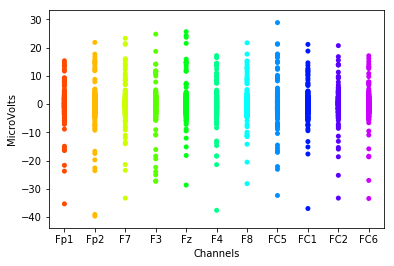

In [128]:
subj.plot_bootstrap(axis=0, colors='gist_rainbow')

In [130]:
sys.getsizeof(subj.boot_store)

17656

In [377]:
glob.glob(os.path.join('C:/Users/Phil/Box Sync/Classes/PSC_290_Final/data', '**', 'EEG', ('*' + '.cnt')))

['C:/Users/Phil/Box Sync/Classes/PSC_290_Final/data\\sub-10\\EEG\\ObjectAttn_10_1.cnt',
 'C:/Users/Phil/Box Sync/Classes/PSC_290_Final/data\\sub-18\\EEG\\ObjectAttn_18_5.cnt',
 'C:/Users/Phil/Box Sync/Classes/PSC_290_Final/data\\sub-21\\EEG\\ObjectAttn_21_1.cnt']